In [1]:
import numpy as np
import seaborn as sns
import os
import time

from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

from Data import Data
from functions import *

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-06-07 13:33:06.975669: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 13:33:07.030213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-

In [2]:
base_path = '/home/aacastro/Alejandro/DQ_ACA_2024/A/ZN_1D_imgs/orig/'
data_processor = Data(base_path)
X, Y, ass_f, ass_l = data_processor.get_data('train.npz', 'validation.npz', 'test.npz', 'assess.npz')
Y = np.argmax(Y, axis=1)

In [3]:
# Crear una máscara booleana para los elementos de Y donde el label sea 0
mask_ok = (Y == 0)
X_filtered_ok = X[mask_ok]
print("Number of Images OK: ", X_filtered_ok.shape[0])

mask_nok = (Y == 1)
X_filtered_nok = X[mask_nok]
print("Number of Images NOK: ", X_filtered_nok.shape[0])

Number of Images OK:  1600
Number of Images NOK:  2882


### Explicación de las Celdas de Código

1. **Aplanar las imágenes a vectores**: Las imágenes se transforman de su forma original a vectores unidimensionales.

2. **Normalización de los datos**: Se normalizan los vectores aplanados para que tengan media 0 y varianza 1.

3. **Reducción de dimensionalidad con PCA**: Se utiliza el Análisis de Componentes Principales (PCA) para reducir la dimensionalidad de los datos a 20 componentes principales, lo que ayuda a simplificar los datos mientras se conserva la mayor parte de la varianza.

4. **Proporción de varianza explicada**: Se calcula la proporción de varianza explicada por cada componente principal y la varianza acumulada. Luego, se determina el número de componentes necesarias para alcanzar el 90% de la varianza explicada.

5. **Cálculo de las distancias euclidianas y visualización de las imágenes**: Se calcula la distancia euclidiana entre las imágenes en el espacio reducido por PCA, se encuentra la imagen que minimiza la distancia promedio con el resto y se visualizan las imágenes más representativas en una cuadrícula.

# OK Images

In [4]:
# Aplanar las imágenes a vectores
X_flattened_ok = X_filtered_ok.reshape(1600, 264 * 18)

scaler = StandardScaler()
X_normalized_ok = scaler.fit_transform(X_flattened_ok)

# Reducción de dimensionalidad a 2D usando PCA
pca_ok = PCA(n_components=18)
X_pca_ok = pca_ok.fit_transform(X_normalized_ok)

# Obtener la proporción de varianza explicada por cada componente principal
explained_variance_ratio_ok = pca_ok.explained_variance_ratio_

# Calcular la varianza explicada acumulada
cumulative_explained_variance_ratio_ok = np.cumsum(explained_variance_ratio_ok)

# Encontrar el número de componentes necesarias para alcanzar el 90% de explicabilidad
n_components_90_ok = np.argmax(cumulative_explained_variance_ratio_ok >= 0.90) + 1

print(f"Número de componentes para alcanzar el 90% de explicabilidad: {n_components_90_ok}")

Número de componentes para alcanzar el 90% de explicabilidad: 18


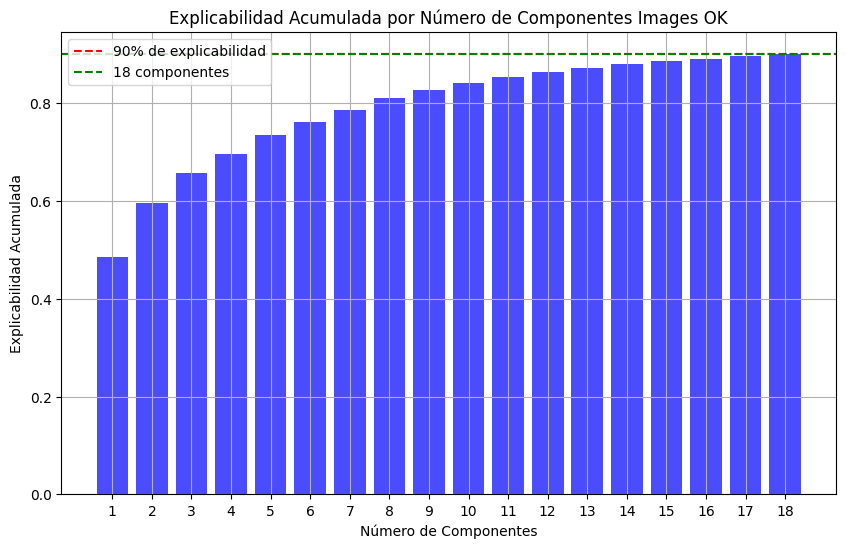

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener la proporción de varianza explicada por cada componente principal
explained_variance_ratio = pca_ok.explained_variance_ratio_

# Calcular la varianza explicada acumulada
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Crear una lista de números de componentes para el eje x
n_components = np.arange(1, len(explained_variance_ratio) + 1)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(n_components, cumulative_explained_variance_ratio, color='blue', alpha=0.7)

# Añadir líneas horizontales en 0.90 y en el porcentaje actual
plt.axhline(y=0.90, color='red', linestyle='--', label='90% de explicabilidad')
plt.axhline(y=cumulative_explained_variance_ratio[n_components_90_ok - 1], color='green', linestyle='--', label=f'{n_components_90_ok} componentes')

# Etiquetas y título
plt.xlabel('Número de Componentes')
plt.ylabel('Explicabilidad Acumulada')
plt.title('Explicabilidad Acumulada por Número de Componentes Images OK')
plt.xticks(n_components)

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [6]:
distances_ok = np.zeros((X_filtered_ok.shape[0], X_filtered_ok.shape[0]))  # Inicializamos una matriz de distancias

for i in range(X_filtered_ok.shape[0]):
    for j in range(X_filtered_ok.shape[0]):
        distances_ok[i, j] = distance.euclidean(X_pca_ok[i], X_pca_ok[j])

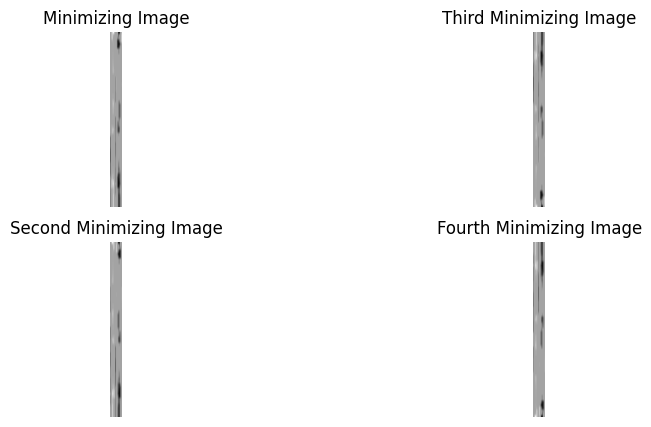

In [7]:
# Calculamos la media de las distancias para cada imagen
mean_distances_ok = np.mean(distances_ok, axis=1)

# Encontramos el índice de la imagen que minimiza la media de distancias
min_distance_index_ok = np.argmin(mean_distances_ok)
second_min_distance_index_ok = np.argsort(mean_distances_ok)[1]
third_min_distance_index_ok = np.argsort(mean_distances_ok)[2]
fourth_min_distance_index_ok = np.argsort(mean_distances_ok)[3]

# La imagen que minimiza la distancia con el resto de imágenes es X[min_distance_index]
imagen_min_distancia_ok = X_filtered_ok[min_distance_index_ok]
imagen_second_min_distancia_ok = X_filtered_ok[second_min_distance_index_ok]
imagen_third_min_distancia_ok = X_filtered_ok[third_min_distance_index_ok]
imagen_fourth_min_distancia_ok = X_filtered_ok[fourth_min_distance_index_ok]

# Visualizamos ambas imágenes
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# Visualización de la primera imagen
axs[0, 0].imshow(imagen_min_distancia_ok, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title('Minimizing Image')

# Visualización de la segunda imagen
axs[1, 0].imshow(imagen_second_min_distancia_ok, cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title('Second Minimizing Image')

# Visualización de la primera imagen
axs[0, 1].imshow(imagen_third_min_distancia_ok, cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title('Third Minimizing Image')

# Visualización de la segunda imagen
axs[1, 1].imshow(imagen_fourth_min_distancia_ok, cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('Fourth Minimizing Image')

plt.show()

# NOK Images

In [8]:
# Aplanar las imágenes a vectores
X_flattened_nok = X_filtered_nok.reshape(2882, 264 * 18)
# X_flattened = X.reshape(4482, 264 * 18)

scaler = StandardScaler()
X_normalized_nok = scaler.fit_transform(X_flattened_nok)

# Reducción de dimensionalidad a 2D usando PCA
pca_nok = PCA(n_components=20)
X_pca_nok = pca_nok.fit_transform(X_normalized_nok)

# Obtener la proporción de varianza explicada por cada componente principal
explained_variance_ratio_nok = pca_nok.explained_variance_ratio_

# Calcular la varianza explicada acumulada
cumulative_explained_variance_ratio_nok = np.cumsum(explained_variance_ratio_nok)

# Encontrar el número de componentes necesarias para alcanzar el 90% de explicabilidad
n_components_90_nok = np.argmax(cumulative_explained_variance_ratio_nok >= 0.90) + 1

print(f"Número de componentes para alcanzar el 90% de explicabilidad: {n_components_90_nok}")

Número de componentes para alcanzar el 90% de explicabilidad: 20


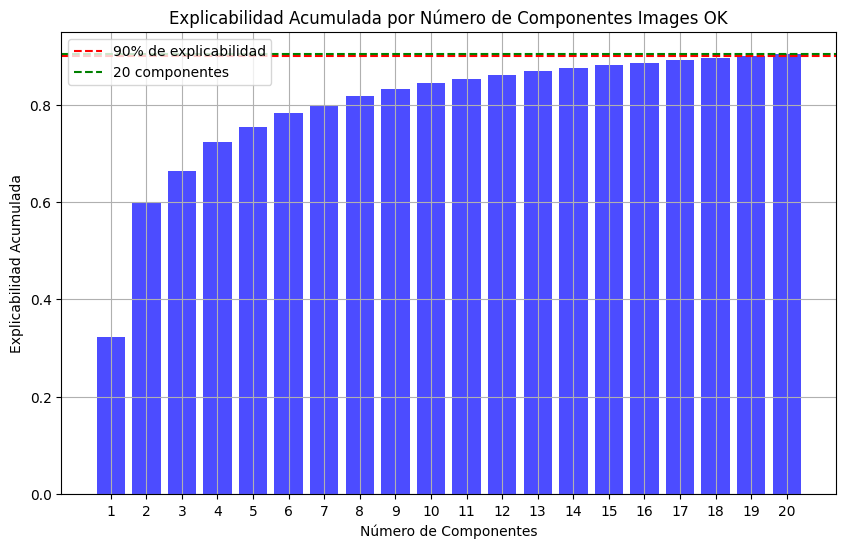

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener la proporción de varianza explicada por cada componente principal
explained_variance_ratio_nok = pca_nok.explained_variance_ratio_

# Calcular la varianza explicada acumulada
cumulative_explained_variance_ratio_nok = np.cumsum(explained_variance_ratio_nok)

# Crear una lista de números de componentes para el eje x
n_components = np.arange(1, len(explained_variance_ratio_nok) + 1)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(n_components, cumulative_explained_variance_ratio_nok, color='blue', alpha=0.7)

# Añadir líneas horizontales en 0.90 y en el porcentaje actual
plt.axhline(y=0.90, color='red', linestyle='--', label='90% de explicabilidad')
plt.axhline(y=cumulative_explained_variance_ratio_nok[n_components_90_nok - 1], color='green', linestyle='--', label=f'{n_components_90_nok} componentes')

# Etiquetas y título
plt.xlabel('Número de Componentes')
plt.ylabel('Explicabilidad Acumulada')
plt.title('Explicabilidad Acumulada por Número de Componentes Images OK')
plt.xticks(n_components)

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [10]:
distances_nok = np.zeros((X_filtered_nok.shape[0], X_filtered_nok.shape[0]))  # Inicializamos una matriz de distancias

for i in range(X_filtered_nok.shape[0]):
    for j in range(X_filtered_nok.shape[0]):
        distances_nok[i, j] = distance.euclidean(X_pca_nok[i], X_pca_nok[j])

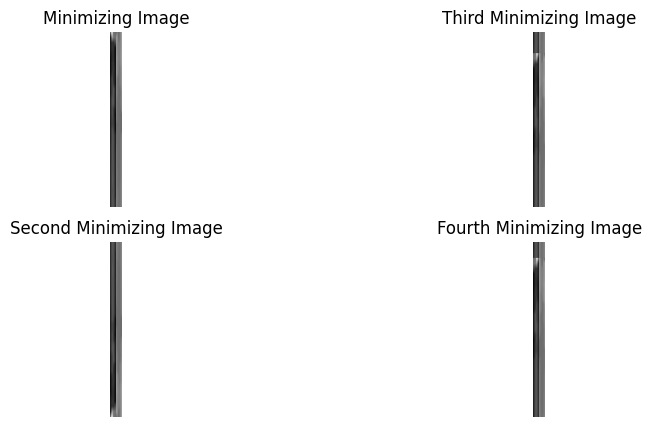

In [11]:
# Calculamos la media de las distancias para cada imagen
mean_distances_nok = np.mean(distances_nok, axis=1)

# Encontramos el índice de la imagen que minimiza la media de distancias
min_distance_index_nok = np.argmin(mean_distances_nok)
second_min_distance_index_nok = np.argsort(mean_distances_nok)[1]
third_min_distance_index_nok = np.argsort(mean_distances_nok)[2]
fourth_min_distance_index_nok = np.argsort(mean_distances_nok)[3]

# La imagen que minimiza la distancia con el resto de imágenes es X[min_distance_index]
imagen_min_distancia_nok = X_filtered_nok[min_distance_index_nok]
imagen_second_min_distancia_nok = X_filtered_nok[second_min_distance_index_nok]
imagen_third_min_distancia_nok = X_filtered_nok[third_min_distance_index_nok]
imagen_fourth_min_distancia_nok = X_filtered_nok[fourth_min_distance_index_nok]

# Visualizamos ambas imágenes
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# Visualización de la primera imagen
axs[0, 0].imshow(imagen_min_distancia_nok, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title('Minimizing Image')

# Visualización de la segunda imagen
axs[1, 0].imshow(imagen_second_min_distancia_nok, cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title('Second Minimizing Image')

# Visualización de la primera imagen
axs[0, 1].imshow(imagen_third_min_distancia_nok, cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title('Third Minimizing Image')

# Visualización de la segunda imagen
axs[1, 1].imshow(imagen_fourth_min_distancia_nok, cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('Fourth Minimizing Image')

plt.show()